In [15]:
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import joblib
import glob

In [3]:
files = glob.glob('initial_data/new_ba_100000/*seed*.csv')
len(files)

1500

In [4]:
df = pd.read_csv(files[0])

In [30]:
df

,S,E,I,R,Beta
0,99500,0,500,0,0.000079
1,95565,3726,661,48,0.000059
2,91868,6877,1130,125,0.000033
3,88436,9506,1801,257,0.000021
4,85045,11812,2711,432,0.000015
...,...,...,...,...,...
245,1696,0,0,98304,0.000000
246,1696,0,0,98304,0.000000
247,1696,0,0,98304,0.000000
248,1696,0,0,98304,0.000000


In [121]:
df[['Beta']].shift(np.arange(2+1)).dropna()

,Beta_0,Beta_1,Beta_2
2,0.000033,0.000059,0.000079
3,0.000021,0.000033,0.000059
4,0.000015,0.000021,0.000033
5,0.000012,0.000015,0.000021
6,0.000010,0.000012,0.000015
...,...,...,...
245,0.000000,0.000000,0.000000
246,0.000000,0.000000,0.000000
247,0.000000,0.000000,0.000000
248,0.000000,0.000000,0.000000


In [37]:
train_df = []
for f in files[:3]:
    seed_df = pd.read_csv(f)

    seed_df = seed_df[(seed_df['E'] > 0)|(seed_df['I'] > 0)].copy()
    #seed_df = seed_df[seed_df['Beta'] > 0].copy()

    seed_df['Beta'] = np.log(seed_df['Beta'] + 1e-7)
    seed_df = seed_df[['Beta']].shift(np.arange(lag)).dropna()
    train_df.append(seed_df)

,Beta_0,Beta_1,Beta_2,Beta_3,Beta_4
0,-11.094903,-10.752566,-10.314162,-9.744332,-9.443591
1,-11.328292,-11.094903,-10.752566,-10.314162,-9.744332
2,-11.498264,-11.328292,-11.094903,-10.752566,-10.314162
3,-11.645123,-11.498264,-11.328292,-11.094903,-10.752566
4,-11.769969,-11.645123,-11.498264,-11.328292,-11.094903
...,...,...,...,...,...
557,-16.118096,-16.118096,-16.118096,-16.118096,-16.118096
558,-16.118096,-16.118096,-16.118096,-16.118096,-16.118096
559,-16.118096,-16.118096,-16.118096,-16.118096,-16.118096
560,-16.118096,-16.118096,-16.118096,-16.118096,-16.118096


In [42]:
pd.concat(train_df, ignore_index=True).drop(columns=['Beta_0'])

,Beta_1,Beta_2,Beta_3,Beta_4
0,-10.752566,-10.314162,-9.744332,-9.443591
1,-11.094903,-10.752566,-10.314162,-9.744332
2,-11.328292,-11.094903,-10.752566,-10.314162
3,-11.498264,-11.328292,-11.094903,-10.752566
4,-11.645123,-11.498264,-11.328292,-11.094903
...,...,...,...,...
557,-16.118096,-16.118096,-16.118096,-16.118096
558,-16.118096,-16.118096,-16.118096,-16.118096
559,-16.118096,-16.118096,-16.118096,-16.118096
560,-16.118096,-16.118096,-16.118096,-16.118096


In [122]:
def load_and_prepare_data(seed_dir, seeds_train, lag,
                          is_filename=False):
    train_df = []
    for i in seeds_train:
        if is_filename:
            seed_df = pd.read_csv(seed_dir+i.split('\\')[-1])
        else:
            seed_df = pd.read_csv(seed_dir+f'seir_seed_{i}.csv')

        seed_df = seed_df[(seed_df['E'] > 0)|(seed_df['I'] > 0)].copy()
        #seed_df = seed_df[seed_df['Beta'] > 0].copy()
        
        seed_df['Beta'] = np.log(seed_df['Beta'] + 1e-7) 
        seed_df = seed_df[['Beta']].shift(np.arange(lag+1)).dropna()
        train_df.append(seed_df)
        
    train_df = pd.concat(train_df, ignore_index=True)
    #train_df = train_df[train_df['Beta'] > 0].copy()

    return train_df


def train_model(train_df, model_file, features, 
                degree=3, alpha=0.0001, max_iter=10000):
    X = train_df.drop(columns=['Beta_0']).values
    y = train_df['Beta_0'].values

    model = make_pipeline(
        StandardScaler(),
        PolynomialFeatures(include_bias=False, degree=degree),
        SGDRegressor(alpha=alpha, max_iter=max_iter, 
                     penalty='l2', warm_start=False)
    )
    model.fit(X, y)
    print(model.score(X, y))
    # Сохраняем лучшую модель
    joblib.dump(model, model_file)

    
def search_params(seed_dir, model_file, df_seeds_n, features,
                 is_filename=False, as_frac=False):
    np.random.seed(42)
    #model = joblib.load(model_file)
    model = make_pipeline(
        StandardScaler(),
        #PolynomialFeatures(include_bias=False),
        SGDRegressor(penalty='l2', warm_start=False, max_iter=10000)
    )
    seeds_2_n = df_seeds_n[df_seeds_n.set!='test']['file'].values
    train_df = load_and_prepare_data(seed_dir, seeds_2_n,
                                    is_filename, as_frac)
    X = train_df.drop(columns=['Beta_0']).values
    y = train_df['Beta_0'].values

    param_distributions = {"sgdregressor__alpha": [0.1,0.05,0.01,0.005,
                                                   0.001,0.0005,0.0001],
                           "polynomialfeatures__degree": [2,3,4]
                          }
    # searches everything, but for future purposes 
    # we have RandomizedSearch, not GridSearch
    search = RandomizedSearchCV(model, param_distributions,
                                n_iter=21,
                                scoring='r2'
                               ).fit(X, y)

    joblib.dump(search.best_estimator_, model_file)

    print(search.best_params_, search.best_score_)
    return search.best_estimator_
    
    
def plot(model_file, train_df, features):
    model = joblib.load(model_file)
    X = train_df.drop(columns=['Beta_0']).values
    y = train_df['Beta_0'].values
    pred = model.predict(X)

    print('MSE: ', mean_squared_error(y, pred), 'r2: ', model.score(X, y))
    fig = plt.figure(figsize=(12, 3)) 
    # how many train points to show
    size = 1500
    plt.plot(y[:size], ls='-', marker='', label='real Beta')
    plt.plot(pred[:size], ls='-', marker='', label='predicted Beta')
    plt.grid()
    plt.legend()


0.7264856636686996
MSE:  0.1303725308540403


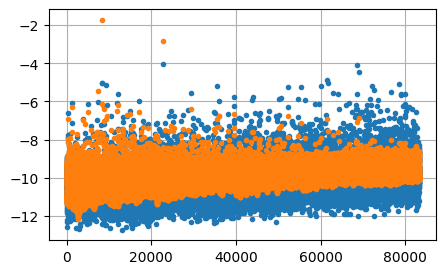

In [4]:
seed_dir='initial_data/initial_data_ba_10000/'
model_file = seed_dir+'regression_day_SEIR_prev_I_for_seir.joblib'


train_df = load_and_prepare_data(seed_dir, seeds_train)
train_model(train_df, model_file, features)
plot(model_file, features)

In [39]:
seed_dir='initial_data/initial_data_ba_50000/'
model_file = seed_dir+'regression_day_SEIR_prev_I_for_seir.joblib'

train_df = load_and_prepare_data(seed_dir, seeds_train)
train_model(train_df, model_file, features)
plot(model_file, features)

FileNotFoundError: [Errno 2] No such file or directory: 'initial_data/initial_data_ba_50000/seir_seed_0.csv'

0.7742044013608336


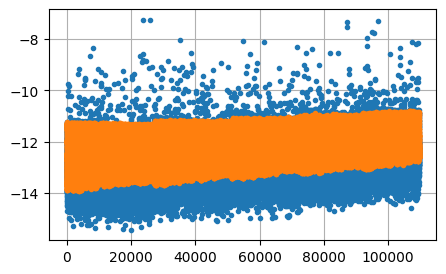

In [71]:
seed_dir='initial_data/initial_data_ba_100000/'
model_file = seed_dir+'regression_day_SEIR_prev_I_for_seir.joblib'

train_df = load_and_prepare_data(seed_dir, seeds_train)
train_model(train_df, model_file, features)
plot(model_file, features)

## new

In [48]:
features = ['day',  
            'S', 
            'E', 
            'I', 
            #'R'
           ]

df_seeds_n = pd.read_csv('initial_data/new_seeds_parameters.csv')
seeds_train_n = df_seeds_n[df_seeds_n.set=='train']['file'].values
seeds_val_n = df_seeds_n[df_seeds_n.set=='val']['file'].values

In [49]:
seed_dir='initial_data/new_ba_100000/'
model_file = seed_dir+'regression_bt.joblib'

val_df = load_and_prepare_data(seed_dir, seeds_val_n,
                                is_filename=True, lag=5)

In [50]:
val_df

,Beta_0,Beta_1,Beta_2,Beta_3,Beta_4
0,-11.078268,-10.824740,-10.258895,-9.806422,-9.479508
1,-11.303735,-11.078268,-10.824740,-10.258895,-9.806422
2,-11.493981,-11.303735,-11.078268,-10.824740,-10.258895
3,-11.644804,-11.493981,-11.303735,-11.078268,-10.824740
4,-11.739222,-11.644804,-11.493981,-11.303735,-11.078268
...,...,...,...,...,...
42217,-16.118096,-16.118096,-16.118096,-16.118096,-16.118096
42218,-16.118096,-16.118096,-16.118096,-16.118096,-16.118096
42219,-16.118096,-16.118096,-16.118096,-16.118096,-16.118096
42220,-16.118096,-16.118096,-16.118096,-16.118096,-16.118096


In [168]:
lag=7

np.random.seed(42)
#model = joblib.load(model_file)
model = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree = 2,include_bias=False),
    SGDRegressor(penalty='l2', warm_start=False, max_iter=10000)
)

val_df = load_and_prepare_data(seed_dir, seeds_val_n,
                                is_filename=True, lag=lag)

X = val_df.drop(columns=['Beta_0']).values
y = val_df['Beta_0'].values

param_distributions = {"sgdregressor__alpha": [0.1,0.01,0.001,0.0005,0.0001],
                       #"polynomialfeatures__degree": [2,3,4]
                      }
# searches everything, but for future purposes 
# we have RandomizedSearch, not GridSearch
search = RandomizedSearchCV(model, param_distributions,
                            n_iter=21,
                            scoring='r2'
                           ).fit(X, y)

C:\Users\user\anaconda3\envs\abm_seir\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 5 is smaller than n_iter=21. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [169]:
search.best_params_

{'sgdregressor__alpha': 0.001}

In [170]:
search.best_score_

np.float64(0.7871803954553426)

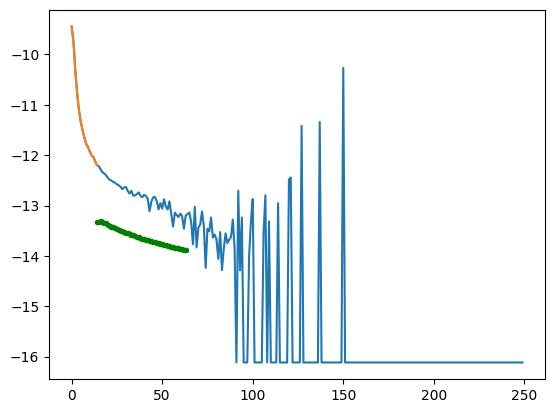

In [173]:
df = pd.read_csv(files[0])
switch=14

plt.plot(np.log(df['Beta']+ 1e-7));
plt.plot(np.log(df.iloc[:switch+1]['Beta']+ 1e-7))

seed_df = df.iloc[switch-lag+1+i : switch+1+i, -1].values[::-1]
seed_df = np.log(seed_df + 1e-7) 

for i in range(50):

    X = seed_df.reshape(1, -1)
    pred = search.predict(X)
    seed_df = np.array([*seed_df[1:], *pred])
    
    plt.plot(switch+i, pred, marker='.', color='green')
    
#plt.plot(seed_df['Beta'])

In [77]:
pred

array([-12.28651997])

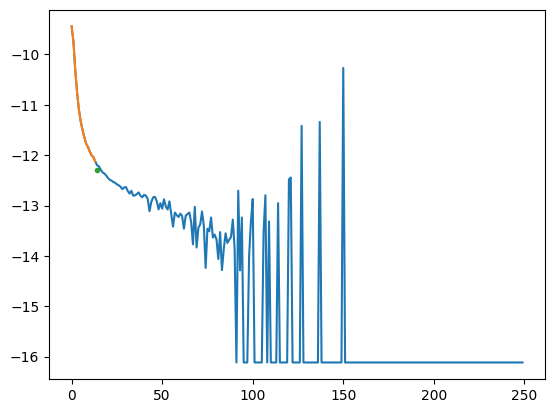

In [86]:

plt.plot(switch, pred, marker='.')

<Axes: >

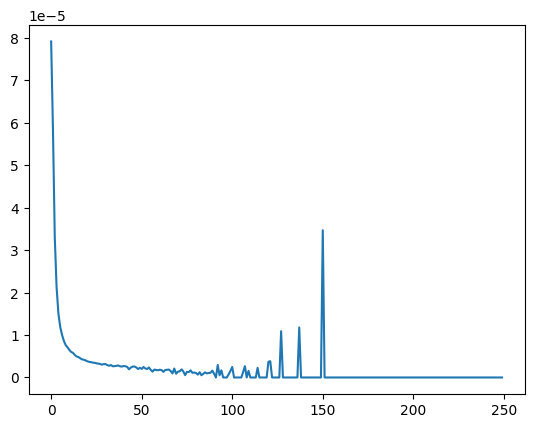

In [60]:
seed_df.Beta.plot()

In [ ]:
seed_dir='initial_data/new_ba_10000/'
model_file = seed_dir+'regression_bt.joblib'

is_filename = True
as_frac=True

est = search_params(seed_dir, model_file, df_seeds_n, features,
                    is_filename=is_filename, as_frac=as_frac)

val_df = load_and_prepare_data(seed_dir, seeds_val_n,
                                is_filename=is_filename, as_frac=as_frac)
plot(model_file, val_df, features)

{'sgdregressor__alpha': 0.001, 'polynomialfeatures__degree': 3} 0.7938561197293359
MSE:  0.1288466365955178 r2:  0.8356702202370322


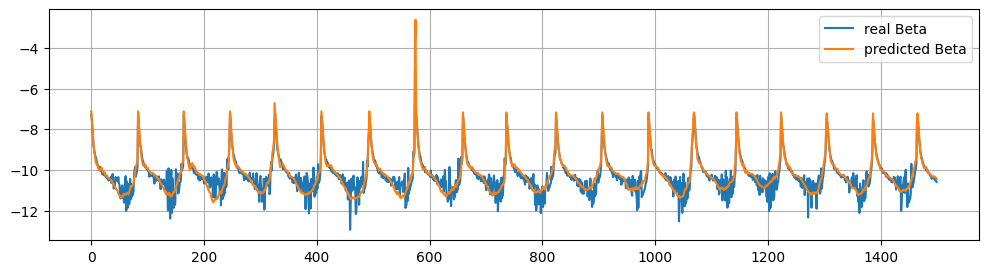

{'sgdregressor__alpha': 0.005, 'polynomialfeatures__degree': 3} 0.7683757070898409
MSE:  0.1426841673724693 r2:  0.8216925955491241


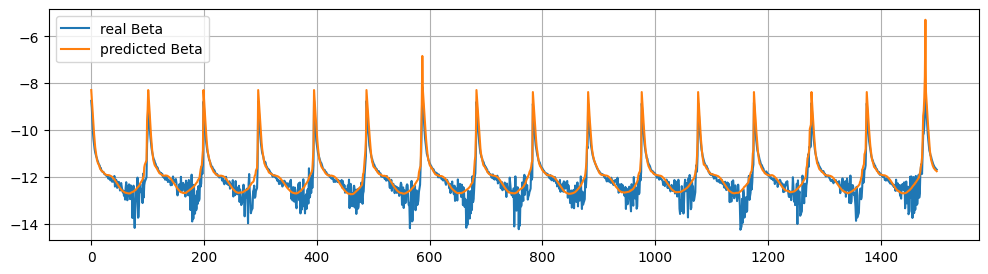

In [11]:
seed_dir='initial_data/new_ba_50000/'
model_file = seed_dir+'regression_day_SEIR_prev_I_for_seir.joblib'

is_filename = True
as_frac=True

est = search_params(seed_dir, model_file, df_seeds_n, features,
                    is_filename=is_filename, as_frac=as_frac)

val_df = load_and_prepare_data(seed_dir, seeds_val_n,
                                is_filename=is_filename, as_frac=as_frac)
plot(model_file, val_df, features)

{'sgdregressor__alpha': 0.01, 'polynomialfeatures__degree': 3} 0.7585264988145715
MSE:  0.1477651361392165 r2:  0.8198623594492485


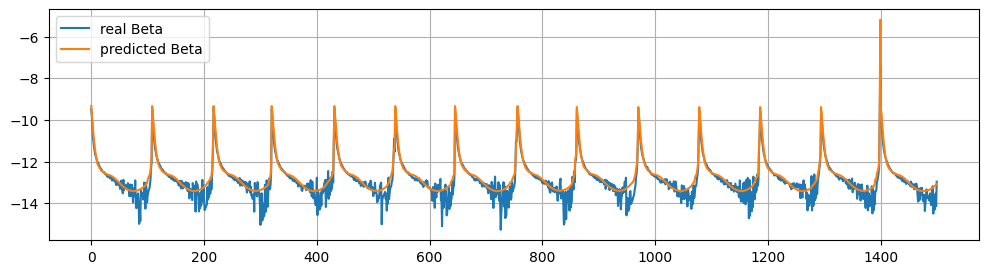

In [5]:
seed_dir='initial_data/new_ba_100000/'
model_file = seed_dir+'regression_day_SEIR_prev_I_for_seir.joblib'

is_filename = True
as_frac=True

est = search_params(seed_dir, model_file, df_seeds_n, features,
                    is_filename=is_filename, as_frac=as_frac)

val_df = load_and_prepare_data(seed_dir, seeds_val_n,
                                is_filename=is_filename, as_frac=as_frac)
plot(model_file, val_df, features)

{'sgdregressor__alpha': 0.005, 'polynomialfeatures__degree': 3} 0.4790795467634611
MSE:  0.11530221736267839 r2:  0.5864240658311701


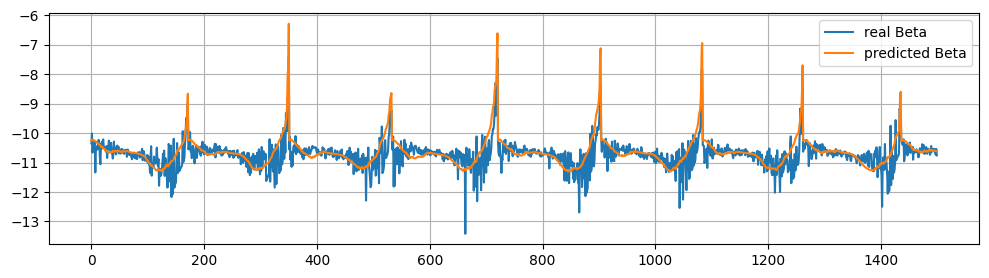

In [12]:
seed_dir='initial_data/new_r_10000/'
model_file = seed_dir+'regression_day_SEIR_prev_I_for_seir.joblib'

is_filename = True
as_frac=True

est = search_params(seed_dir, model_file, df_seeds_n, features,
                    is_filename=is_filename, as_frac=as_frac)

val_df = load_and_prepare_data(seed_dir, seeds_val_n,
                                is_filename=is_filename, as_frac=as_frac)
plot(model_file, val_df, features)

C:\Users\user\anaconda3\envs\abm_seir\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\user\anaconda3\envs\abm_seir\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\user\anaconda3\envs\abm_seir\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


{'sgdregressor__alpha': 0.005, 'polynomialfeatures__degree': 4} 0.5871287735232995
MSE:  0.09284839682278738 r2:  0.6768588811571279


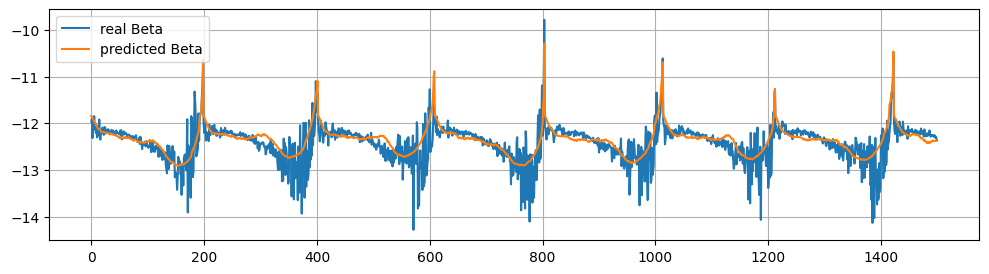

In [10]:
seed_dir='initial_data/new_r_50000/'
model_file = seed_dir+'regression_day_SEIR_prev_I_for_seir.joblib'

is_filename = True
as_frac=True

est = search_params(seed_dir, model_file, df_seeds_n, features,
                    is_filename=is_filename, as_frac=as_frac)

val_df = load_and_prepare_data(seed_dir, seeds_val_n,
                                is_filename=is_filename, as_frac=as_frac)
plot(model_file, val_df, features)

C:\Users\user\anaconda3\envs\abm_seir\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\user\anaconda3\envs\abm_seir\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\user\anaconda3\envs\abm_seir\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\user\anaconda3\envs\abm_seir\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


{'sgdregressor__alpha': 0.01, 'polynomialfeatures__degree': 4} 0.638007859644657
MSE:  0.0876084796447788 r2:  0.7167287504308884


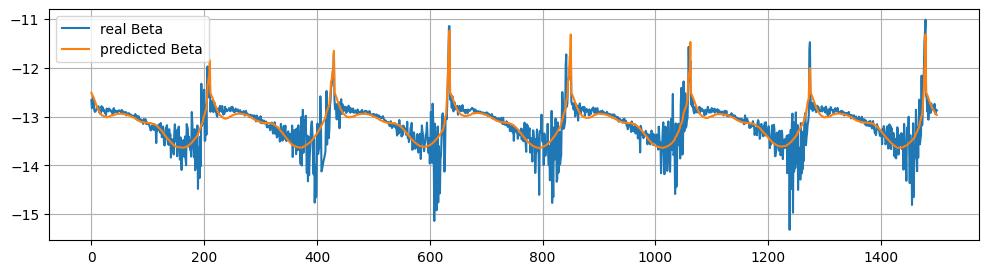

In [11]:
seed_dir='initial_data/new_r_100000/'
model_file = seed_dir+'regression_day_SEIR_prev_I_for_seir.joblib'

is_filename = True
as_frac=True

est = search_params(seed_dir, model_file, df_seeds_n, features,
                    is_filename=is_filename, as_frac=as_frac)

val_df = load_and_prepare_data(seed_dir, seeds_val_n,
                                is_filename=is_filename, as_frac=as_frac)
plot(model_file, val_df, features)

C:\Users\user\anaconda3\envs\abm_seir\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\user\anaconda3\envs\abm_seir\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


{'sgdregressor__alpha': 0.01, 'polynomialfeatures__degree': 3} 0.6228856120316372
MSE:  0.13750176816713938 r2:  0.7642010086606452


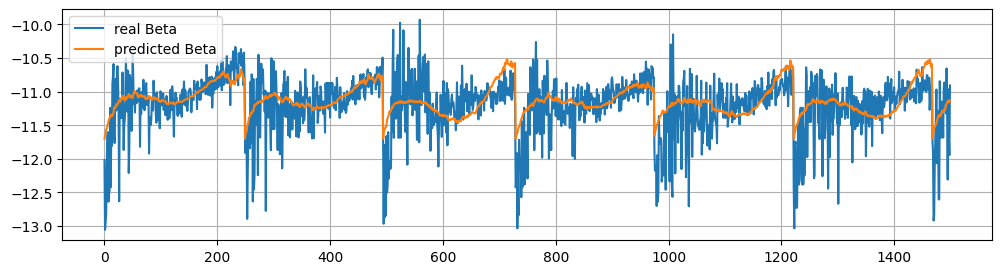

In [12]:
seed_dir='initial_data/new_sw_10000/'
model_file = seed_dir+'regression_day_SEIR_prev_I_for_seir.joblib'

is_filename = True
as_frac=True

est = search_params(seed_dir, model_file, df_seeds_n, features,
                    is_filename=is_filename, as_frac=as_frac)

val_df = load_and_prepare_data(seed_dir, seeds_val_n,
                                is_filename=is_filename, as_frac=as_frac)
plot(model_file, val_df, features)

{'sgdregressor__alpha': 0.005, 'polynomialfeatures__degree': 3} 0.7443353555562411
MSE:  0.07891268818921246 r2:  0.8554380683779339


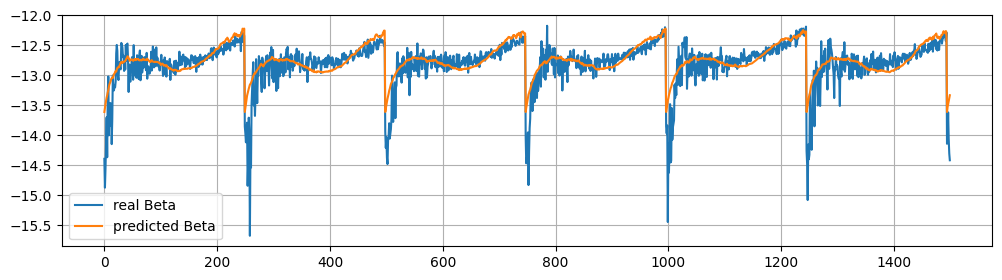

In [13]:
seed_dir='initial_data/new_sw_50000/'
model_file = seed_dir+'regression_day_SEIR_prev_I_for_seir.joblib'

is_filename = True
as_frac=True

est = search_params(seed_dir, model_file, df_seeds_n, features,
                    is_filename=is_filename, as_frac=as_frac)

val_df = load_and_prepare_data(seed_dir, seeds_val_n,
                                is_filename=is_filename, as_frac=as_frac)
plot(model_file, val_df, features)

{'sgdregressor__alpha': 0.005, 'polynomialfeatures__degree': 3} 0.7916637055831286
MSE:  0.062024148959926216 r2:  0.8830087411255223


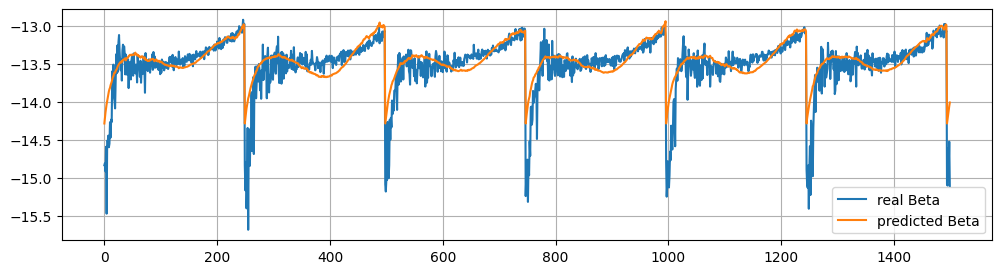

In [13]:
seed_dir='initial_data/new_sw_100000/'
model_file = seed_dir+'regression_day_SEIR_prev_I_for_seir.joblib'

is_filename = True
as_frac=True

est = search_params(seed_dir, model_file, df_seeds_n, features,
                    is_filename=is_filename, as_frac=as_frac)

val_df = load_and_prepare_data(seed_dir, seeds_val_n,
                                is_filename=is_filename, as_frac=as_frac)
plot(model_file, val_df, features)

## small world

0.7831986579904753


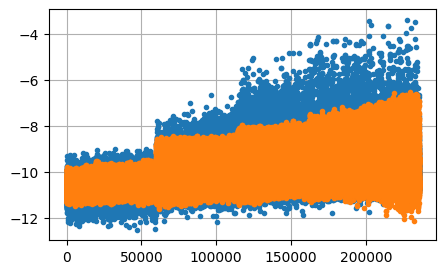

In [73]:
seed_dir='initial_data/initial_data_sw_10000/'
model_file = seed_dir+'regression_day_SEIR_prev_I_for_seir.joblib'

train_df = load_and_prepare_data(seed_dir, seeds_train)
train_model(train_df, model_file, features)
plot(model_file, features)

0.7995411630648883


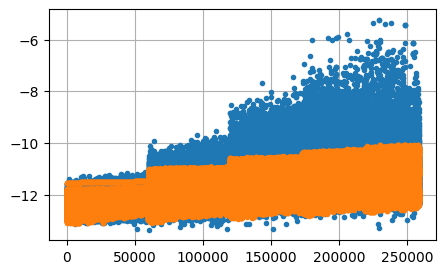

In [84]:
seed_dir='initial_data/initial_data_sw_50000/'
model_file = seed_dir+'regression_day_SEIR_prev_I_for_seir.joblib'

train_df = load_and_prepare_data(seed_dir, seeds_train)
train_model(train_df, model_file, features)
plot(model_file, features)

0.8006524916040959


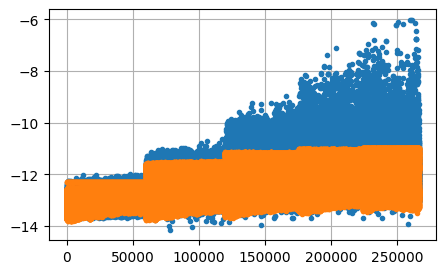

In [86]:
seed_dir='initial_data/initial_data_sw_100000/'
model_file = seed_dir+'regression_day_SEIR_prev_I_for_seir.joblib'

train_df = load_and_prepare_data(seed_dir, seeds_train)
train_model(train_df, model_file, features)
plot(model_file, features)

## random

0.5618567014420793
MSE:  0.11139942909935087


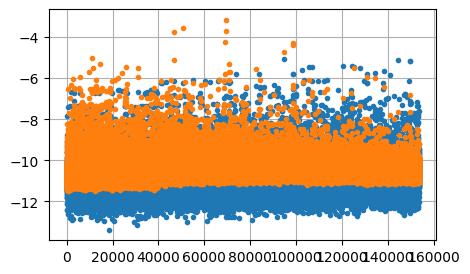

In [5]:
seed_dir='initial_data/initial_data_r_10000/'
model_file = seed_dir+'regression_day_SEIR_prev_I_for_seir.joblib'

train_df = load_and_prepare_data(seed_dir, seeds_train)
train_model(train_df, model_file, features)
plot(model_file, features)

0.5955909773013708
MSE:  0.11026524559092088


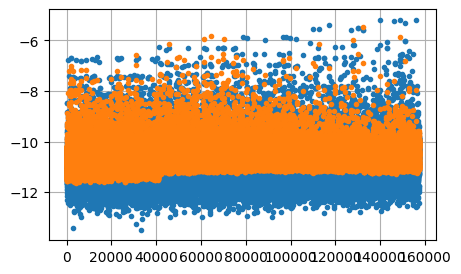

In [6]:
df_seeds_n = pd.read_csv('initial_data/new_seeds_parameters.csv')
seeds_train_n = df_seeds_n[df_seeds_n.set!='test']['file'].values

seed_dir='initial_data/new_r_10000/'
model_file = seed_dir+'regression_day_SEIR_prev_I_for_seir.joblib'

train_df = load_and_prepare_data(seed_dir, seeds_train_n,
                                is_filename=True)
train_model(train_df, model_file, features)
plot(model_file, features)

0.6352484969279337
MSE:  0.10081997521356312


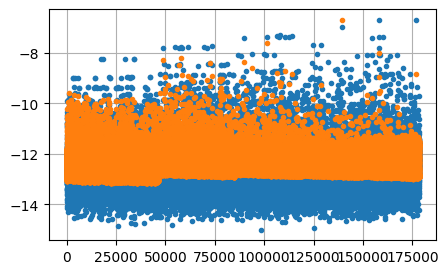

In [5]:
seed_dir='initial_data/initial_data_r_50000/'
model_file = seed_dir+'regression_day_SEIR_prev_I_for_seir.joblib'

train_df = load_and_prepare_data(seed_dir, seeds_train)
train_model(train_df, model_file, features)
plot(model_file, features)

0.6529889991426283
MSE:  0.09847972522478192


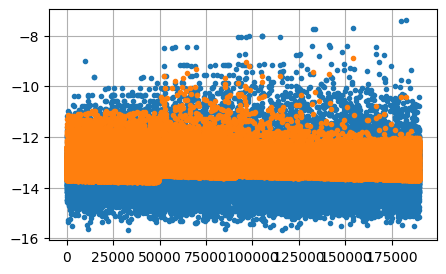

In [7]:
seed_dir='initial_data/initial_data_r_100000/'
model_file = seed_dir+'regression_day_SEIR_prev_I_for_seir.joblib'

train_df = load_and_prepare_data(seed_dir, seeds_train)
train_model(train_df, model_file, features)
plot(model_file, features)

0.6737600829699402
MSE:  0.10073813081773021


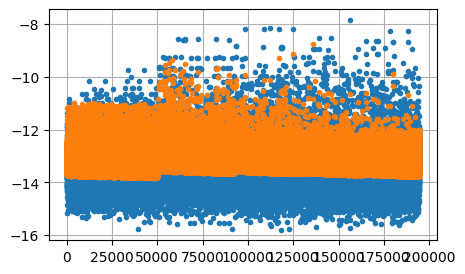

In [8]:
df_seeds_n = pd.read_csv('initial_data/new_seeds_parameters.csv')
seeds_train_n = df_seeds_n[df_seeds_n.set!='test']['file'].values

seed_dir='initial_data/new_r_100000/'
model_file = seed_dir+'regression_day_SEIR_prev_I_for_seir.joblib'

train_df = load_and_prepare_data(seed_dir, seeds_train_n,
                                is_filename=True)
train_model(train_df, model_file, features)
plot(model_file, features)